# NFL Kicker Analysis
***

Welcome to the NFL kicker's performance analysis! We'll take a dive on the data from kickers from 2006 and 2020. Are the kickers getting better over the years? How do their performance change in high pressure situations? At what age do kickers reach their peak? We'll try to get some of these answers. The full project can be found in my <a href="https://github.com/DanielEliezer/nfl_kickers_analysis"> github repository. </a>.

#### In this project, we’ll try to answer the followings:
<br>1) What is the probability of scoring as a function of the kick distance ? What's the average accuracy at the "field goal range"?
<br>2) What are the best and worst teams in the NFL kicking? And the best players?
<br>3) Do kickers feel the pressure? Their performance is worse when they are playing away from home? What about in games between division rivals? And in crucial moments?
<br>4) Are the kickers improving their performance over the years?
<br>5) At what ages do the kickers hit their prime?
<br>	
	Ready? Let’s go!

***

In [1]:
## Imports

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from dateutil.relativedelta import relativedelta
from datetime import timedelta
from scipy.stats import chisquare
import random
from scipy import stats
import statistics
import plotly.express as px
from mlxtend.evaluate import permutation_test


## defining functions

def find_penalty_block(s):
    """
    Find plays where the kick was blocked, or the offense commited a penalty
    """
    if s.lower().find('penalty')>=0:
        return 1
    if s.lower().find('block')>=0:
        return 1
    
    else:
        return 0

def fill_na_values(df):
    """
    Fill the null fields with the correct values
    """
    list_aux = []
    for i in range(len(df['season'])):

        if (pd.isna(df.loc[i, 'distance'])) & (df.loc[i, 'season'] < 2015):
            list_aux.append(20)
        elif (pd.isna(df.loc[i, 'distance'])) & (df.loc[i, 'season'] >= 2015):
            list_aux.append(33)  
        else:
            list_aux.append(df.loc[i, 'distance'])
        
    df['distance'] = list_aux
    
def strip_space(st):
    """
    Remove the spaces from the string
    """
    return st.replace(" ", "")

import warnings
warnings.filterwarnings("ignore")

dic_division = {'New England Patriots':'AFC_E', 'Buffalo Bills':'AFC_E', 'Chicago Bears':'NFC_N',
'Cleveland Browns':'AFC_N', 'Houston Texans':'AFC_S', 'Miami Dolphins':'AFC_E',
'New Orleans Saints':'NFC_S', 'New York Jets':'AFC_E', 'Pittsburgh Steelers':'AFC_N',
'Los Angeles Rams':'NFC_W', 'Washington Football Team':'NFC_E',
'Minnesota Vikings':'NFC_N', 'Philadelphia Eagles':'NFC_E', 'San Francisco 49ers':'NFC_W',
'Denver Broncos':'AFC_W', 'Carolina Panthers':'NFC_S', 'Atlanta Falcons':'NFC_S',
'Baltimore Ravens':'AFC_N', 'Detroit Lions':'NFC_N', 'Green Bay Packers':'NFC_N',
'Jacksonville Jaguars':'AFC_S', 'Kansas City Chiefs':'AFC_W', 'New York Giants':'NFC_E',
'Tennessee Titans':'AFC_S', 'Tampa Bay Buccaneers':'NFC_S', 'Arizona Cardinals':'NFC_W',
'Dallas Cowboys':'NFC_E', 'Las Vegas Raiders':'AFC_W', 'Los Angeles Chargers':'AFC_W',
'Cincinnati Bengals':'AFC_N', 'Indianapolis Colts':'AFC_S', 'Seattle Seahawks':'NFC_W'}

## Creating the main dataset
***

The data was crafted from these kaggle datasets <a href="https://www.kaggle.com/toddsteussie/nfl-play-statistics-dataset-2004-to-present"> [1] </a> <a href="https://www.kaggle.com/competitions/nfl-big-data-bowl-2021/data?select=plays.csv"> [2] </a>. The original data contains a full play-by-play report of all games in the NFL. It's a very big folder with a lot of csv files that can generate a lot of exciting analysis for the football fans.

In [2]:
plays = pd.read_csv('plays.csv', index_col = 0)
plays.head()

,game_id,home_team,away_team,possession_team,nonpossession_team,play_type,yardline,home_score_pre,visiting_score_pre,description,scored,kicker_name,quarter
0,26909,New England Patriots,Indianapolis Colts,Indianapolis Colts,New England Patriots,Extra Point,2.0,3,3,Extra Point - Good: IND 13 (M.Vanderjagt),1,M.Vanderjagt,2
1,26909,New England Patriots,Indianapolis Colts,Indianapolis Colts,New England Patriots,Extra Point,2.0,10,10,Extra Point - Good: IND 13 (M.Vanderjagt),1,M.Vanderjagt,2
2,26909,New England Patriots,Indianapolis Colts,Indianapolis Colts,New England Patriots,Extra Point,2.0,27,17,Extra Point - Good: IND 13 (M.Vanderjagt),1,M.Vanderjagt,4
3,26909,New England Patriots,Indianapolis Colts,Indianapolis Colts,New England Patriots,Field Goal,14.0,3,0,"Field Goal Yards: IND 13 (M.Vanderjagt), 32 yards",1,M.Vanderjagt,2
4,26909,New England Patriots,Indianapolis Colts,Indianapolis Colts,New England Patriots,Field Goal,29.0,27,24,Field Goal Missed Yards: IND 13 (M.Vanderjagt)...,0,M.Vanderjagt,4


In [3]:
## import games dataset
games = pd.read_csv('games.csv', index_col = 0)
games.head()

,gameId,season,week,gameDate,home_team,away_team
0,26909,2004,1,2004-09-09,New England Patriots,Indianapolis Colts
1,26914,2004,1,2004-09-11,Miami Dolphins,Tennessee Titans
2,26913,2004,1,2004-09-12,Houston Texans,Los Angeles Chargers
3,26915,2004,1,2004-09-12,New Orleans Saints,Seattle Seahawks
4,26916,2004,1,2004-09-12,New York Jets,Cincinnati Bengals


In [4]:
# joining the data
df = plays.merge(games[['gameId','season','gameDate','week']], left_on = 'game_id', right_on = 'gameId')
df.drop('gameId', inplace = True, axis = 1)

# create column to indicate the number of points earned if kick is good 
df.loc[df['play_type'] == 'Extra Point' ,'potential_pts'] = 1
df.loc[df['play_type'] == 'Field Goal' ,'potential_pts'] = 3

# indicates what team is kicking (home/away)
df['team_kicking'] = df['home_team']==df['possession_team']
df.loc[df['team_kicking'] == True ,'team_kicking'] = 'Home'
df.loc[df['team_kicking'] == False ,'team_kicking'] = 'Away'

# create a column for play_id
df = df.reset_index().rename({'index':'play_id'}, axis = 1)

# create a column to indicate if the game is between two division rivals
df['div_possession_team'] = df['possession_team'].map(dic_division)
df['div_non_possession_team'] = df['nonpossession_team'].map(dic_division)


display(df.head())
display(df.shape)


,play_id,game_id,home_team,away_team,possession_team,nonpossession_team,play_type,yardline,home_score_pre,visiting_score_pre,...,scored,kicker_name,quarter,season,gameDate,week,potential_pts,team_kicking,div_possession_team,div_non_possession_team
0,0,26909,New England Patriots,Indianapolis Colts,Indianapolis Colts,New England Patriots,Extra Point,2.0,3,3,...,1,M.Vanderjagt,2,2004,2004-09-09,1,1.0,Away,AFC_S,AFC_E
1,1,26909,New England Patriots,Indianapolis Colts,Indianapolis Colts,New England Patriots,Extra Point,2.0,10,10,...,1,M.Vanderjagt,2,2004,2004-09-09,1,1.0,Away,AFC_S,AFC_E
2,2,26909,New England Patriots,Indianapolis Colts,Indianapolis Colts,New England Patriots,Extra Point,2.0,27,17,...,1,M.Vanderjagt,4,2004,2004-09-09,1,1.0,Away,AFC_S,AFC_E
3,3,26909,New England Patriots,Indianapolis Colts,Indianapolis Colts,New England Patriots,Field Goal,14.0,3,0,...,1,M.Vanderjagt,2,2004,2004-09-09,1,3.0,Away,AFC_S,AFC_E
4,4,26909,New England Patriots,Indianapolis Colts,Indianapolis Colts,New England Patriots,Field Goal,29.0,27,24,...,0,M.Vanderjagt,4,2004,2004-09-09,1,3.0,Away,AFC_S,AFC_E


(37022, 21)

## Data Cleaning
***

Like every data science project, we must check for inconsistencies in the dataset and fix them. 

First of all:
Checking at the values of yardline, this number is the distance between the beginning of the play to the end zone. What we actually want is where the kick hits the ball. Therefore, we need to add 18 yards to this number.

In [5]:
# get the distance of the kick
df['distance']= df['yardline'] + 18
df = df.drop('yardline', axis = 1)

Some rows have a unwanted whitespace in the kicker name, let's fix that:

In [6]:
# fix kicker name
df['kicker_name'] = df['kicker_name'].apply(strip_space)

Now, the good and old check for nulls

In [7]:
## Checking for nulls
df.isnull().sum()

play_id                      0
game_id                      0
home_team                    0
away_team                    0
possession_team              0
nonpossession_team           0
play_type                    0
home_score_pre               0
visiting_score_pre           0
description                  0
scored                       0
kicker_name                  0
quarter                      0
season                       0
gameDate                     0
week                         0
potential_pts                0
team_kicking                 0
div_possession_team          0
div_non_possession_team      0
distance                   926
dtype: int64

For some reason, some data weren't filled correctly. Luckily, all of them are from extra points, and these numbers can be easily filled: Before 2015, the distance of the field goal was 20 yards. After that, they changed it to 33. Let’ fix it.

In [8]:
fill_na_values(df)

## Checking for nulls
df.isnull().sum()

play_id                    0
game_id                    0
home_team                  0
away_team                  0
possession_team            0
nonpossession_team         0
play_type                  0
home_score_pre             0
visiting_score_pre         0
description                0
scored                     0
kicker_name                0
quarter                    0
season                     0
gameDate                   0
week                       0
potential_pts              0
team_kicking               0
div_possession_team        0
div_non_possession_team    0
distance                   0
dtype: int64

That's good, we got rid of all the null values! We are almost done:

Finally, we have two more issues:
- in some of the plays, we can have an offensive penalty, and the kick won't be valid. We should exclude these attempts from the dataset.
- in some plays, the kick is blocked. When this happens, most of the time it's because of an error from the blockers, the snapper, or the holder. Therefore, I prefer to drop this attempts (even if that's a little debatable)

In [9]:
df['have_penalty_or_block'] = df['description'].apply(find_penalty_block)
df = df[df['have_penalty_or_block']==0].reset_index(drop = True).drop('have_penalty_or_block', axis = 1)

Now that have a clean dataset, let's find some answers!

## What is the mean accuracy of the kick, given a certain distance? What is the probability of scoring in the "field goal range"?
***

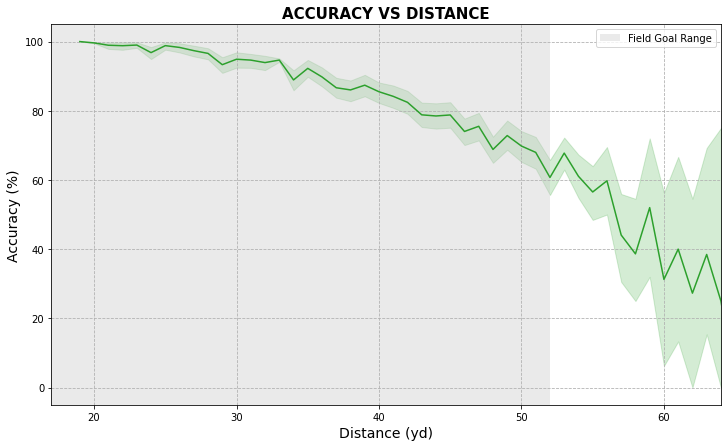

In [10]:
# Plotting
fig = plt.subplots(figsize=(12,7))
plt.title("ACCURACY VS DISTANCE", fontweight = 'bold', fontsize = 15)
ax = sns.lineplot(x = df['distance'], y = df['scored']*100,   color = 'tab:green')
plt.axvspan(0, 52, facecolor='0.8', alpha=0.4, label="Field Goal Range")
plt.xlabel("Distance (yd)", fontsize = 14)
plt.ylabel("Accuracy (%)", fontsize = 14)
plt.xlim(17,64)
plt.grid(linestyle = '--')
plt.legend()
plt.show();

Looking at the curve, we can see some things:

- As expected, as the kick gets longer, the accuracy decreases and the variance increases.


- For shorter kicks, the accuracy decreases very smoothly. As they get longer, this drop is more pronounced, and after the field goal range, this drop is very fast. At 52 yards, the accuracy is 67%, after just 2 yards, the accuracy falls to 56%.


- We can see that the accuracy in the field goal range limit (52 yd) is 61%. After that, it falls very quickly.


- The curve has some odd behaviours: At some points, we can see that the accuracy is higher than a slighty shorter kick. That doesn't make a lot of sense, and it might be happening because the number of attempts is not high enough. If we had a bigger dataset, that behavior probably woudn't hold.



## What are the best/worst teams in the NFL kicking the ball? And how about the players?
***


## Defining an evaluation metric

To our problem: when comparing the teams, how can we indicate which one is the best at kicking?

The first idea is to rank them by accuracy (number of kicks converted / total attempts). Makes sense, right?

But hold on... we are trying to understand **how good** are the teams on kicking the ball. Let's consider the team A and team B for a while:

**Team A:** 92% accuracy, 30 yard kicks on average.

**Team B**: 90% accuracy, 45 yard kicks on average.

Even though the team B have a smaller accuracy, it might be fair to say that they are better on kicking the ball, since their kicks are from farther away.

Therefore, **we need to consider the difficulty of the kicks in the calculation**, after all, it makes sense to assume that the kicks difficulty are systematically different among teams, and that difference is not due to chance: Maybe a team is so good that most of their attempts are from extra points. Maybe a team is always behind on the scoreboard and needs to go to 4th down on some situations of an easy kick. Maybe it's the opposite: a team is always on ahead, and don't need to risk difficult kicks... Not to mention that if a team know that it's kicker is terrible, they might not rely on him on longer field goals.


### Creating a metric.

Here is how we can do do it: For every kick, **we are going to calculate the "probability of scoring"**, based on the accuracy of the whole league, for kicks in that same distance. 

After that, for each team, we'll separate the kicks they've taken, and run some simulations based on the probability of scoring each kick. After that, we can see the distribution of accuracys, and how the real performance compares to the median of the simulations: Using this method, we can see which teams exceeded expectations, and which did not.

Let's make a quick case study! I'll pick a random team to ilustrate it. How about the Cincinnati Bengals?

In [11]:
## Creating a auxiliar dataset to hold the probability of scoring a kick in a given distance
df_distance = df.groupby('distance').mean()[['scored']].reset_index().rename({'scored':'scoring_prob'}, axis = 1)
df_distance.sample(5)

,distance,scoring_prob
17,36.0,0.897727
40,59.0,0.520000
16,35.0,0.922566
31,50.0,0.697970
23,42.0,0.824380


In [12]:
# merging to the original
df = df.merge(df_distance, on = 'distance')

In [13]:
# creating a dataset only with the bengals attempts
df_bengals = df[df['possession_team']=='Cincinnati Bengals']

# creating a list with the probability of scoring each kick attempted from the Bengals
list_probabilities = df_bengals['scoring_prob'].tolist()
list_accuracy_simulations = [] ## will hold the accuracy of each simulation

# running the simulations
random.seed(123)
for n in range(10000):
    list_scored = [] ## will the output of each kick in the simulation (1 = scored, 0 = miss)
    for i in list_probabilities:
        if (random.random()) > i:
            list_scored.append(0)
        else:
            list_scored.append(1)
        
    list_accuracy_simulations.append(sum(list_scored)*100/len(list_scored)) 

The real accuracy is: 92.11 %
The expected accuracy is: 92.74 %


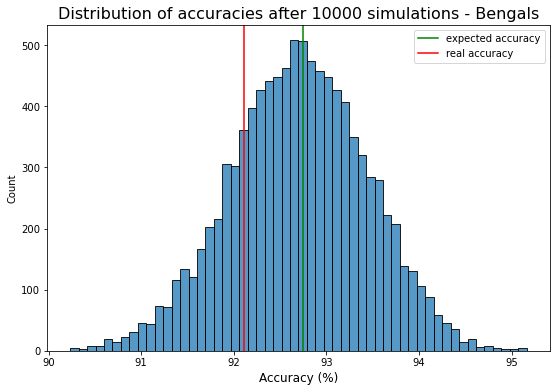

In [14]:
# plotting the result of the simulations
plt.figure(figsize = (9,6))
plt.title('Distribution of accuracies after 10000 simulations - Bengals', fontsize = 16)
ax = sns.histplot(list_accuracy_simulations)
plt.axvline(x = np.median(list_accuracy_simulations), color = 'green', label = 'expected accuracy')
plt.axvline(x = df_bengals.mean()['scored']*100, color = 'red', label = 'real accuracy')
plt.xlabel('Accuracy (%)', fontsize = 12)
plt.legend();

print("The real accuracy is:", round(df_bengals.mean()['scored']*100,2),'%')
print("The expected accuracy is:", round(np.median(list_accuracy_simulations),2),'%')



From the histogram, we can have a very good sense that the real accuracy was bellow the expected. In fact, it was only better than about 20% of the simulations. 

This method seems to have worked well! **Calculating the difference between the real accuracy and the expected can give us a great sense on how good is the team.** That's how we are going to evaluate the players/teams from now on!

In [15]:
# create function to evaluate a group
def run_simulations(dataframe, group, n_sim):
    df_group_aux = pd.DataFrame()
    random.seed(123)
    list_probabilities = []
    for unit in dataframe[group].unique():
        list_probabilities = df[df[group]==unit]['scoring_prob'].tolist()
    
        list_accuracy_simulations = []
        
        for n in range(n_sim):
            list_scored = []
            for prob in list_probabilities:
                if (random.random()) > prob:
                    list_scored.append(0)
                else:
                    list_scored.append(1)
            list_accuracy_simulations.append(sum(list_scored)*100/len(list_scored)) 
        df_group_aux.loc[unit, 'expected_accuracy'] = statistics.median(list_accuracy_simulations)

    df_group_aux = df_group_aux.reset_index().rename({'index':group}, axis = 1)
    df_group_aux = df_group_aux.merge(df.groupby(group).mean()[['scored']].reset_index(), on = group)
    df_group_aux['scored'] = df_group_aux['scored']*100 
    df_group_aux['dif'] = df_group_aux['scored'] - df_group_aux['expected_accuracy']
    df_group_aux = df_group_aux.rename({'scored':'accuracy'}, axis = 1)
    
    df_group_aux = df_group_aux.sort_values('accuracy', ascending = False).reset_index(drop = True).reset_index().rename({'index':'rank_acc'}, axis = 1)
    df_group_aux = df_group_aux.sort_values('dif', ascending = False).reset_index(drop = True).reset_index().rename({'index':'rank_dif'}, axis = 1)
    df_group_aux['rank_var'] = df_group_aux['rank_acc'] - df_group_aux['rank_dif']
    df_group_aux = df_group_aux[[group, 'accuracy', 'expected_accuracy', 'dif', 'rank_var']]
    return df_group_aux




### Best Teams
To determine how good is a certain group of kickers, we'll simply measure their accuracy (kicks scored/kicks attempted)

In [16]:
df_team_aux = run_simulations(df, 'possession_team', 10000).sort_values('accuracy', ascending = False)

In [17]:
df_team_aux2 = df_team_aux.copy()

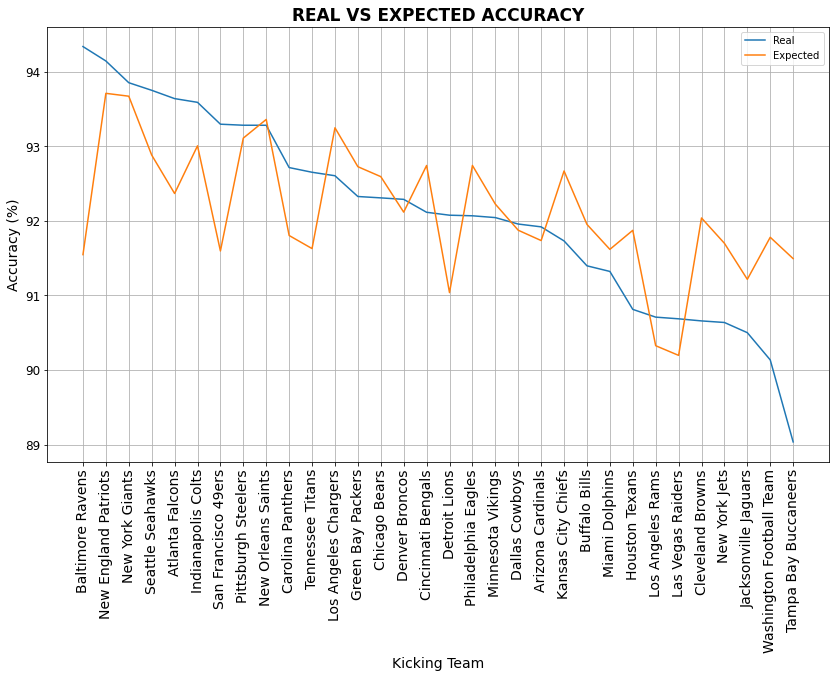

''

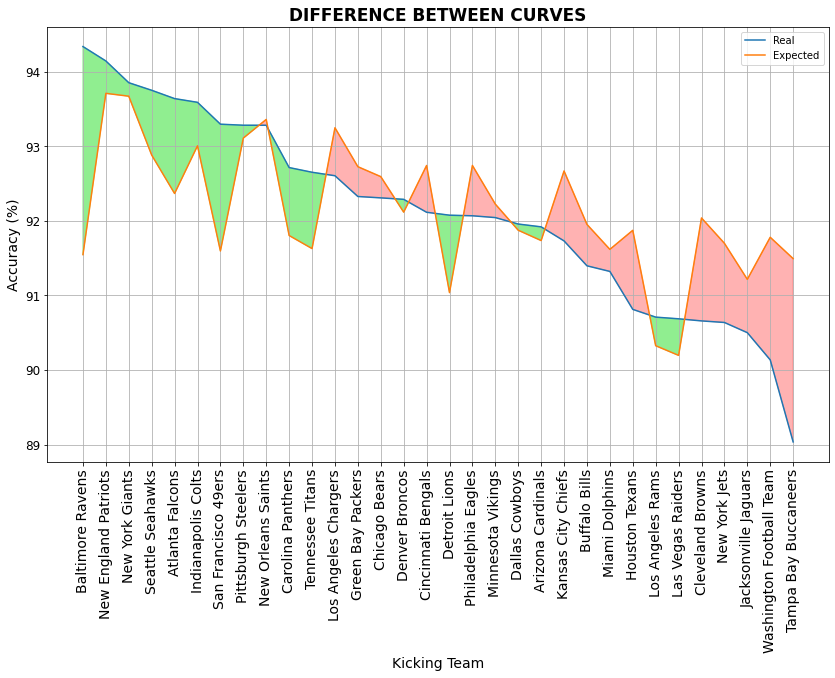

In [18]:
## plotting

x1 = df_team_aux['possession_team']
y1 = df_team_aux['accuracy']
y2 = df_team_aux['expected_accuracy'] 

plt.figure(figsize = (14,8))
ax = sns.lineplot(x = x1, y = y1, label = 'Real')
ax = sns.lineplot(x = x1, y = y2, label = 'Expected')
plt.title('REAL VS EXPECTED ACCURACY', fontweight = 'bold', size = 17)
plt.xlabel('Kicking Team', size = 14)
plt.ylabel('Accuracy (%)', size = 14)
plt.legend()
plt.xticks(rotation = 90)
plt.grid()

ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=14)

plt.show()

plt.figure(figsize = (14,8))
ax = sns.lineplot(x = x1, y = y1, label = 'Real')
ax = sns.lineplot(x = x1, y = y2, label = 'Expected')
plt.title('DIFFERENCE BETWEEN CURVES', fontweight = 'bold', size = 17)
plt.xlabel('Kicking Team', size = 14)
plt.ylabel('Accuracy (%)', size = 14)
plt.legend()
plt.xticks(rotation = 90)
plt.grid()

ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=14)

ax.fill_between(x1, y1, y2, where=(y1 >= y2), color = 'lightgreen', interpolate = True)
ax.fill_between(x1, y1, y2, where=(y1 < y2), color = 'red', alpha=0.3,interpolate = True)

;

We can see a lot from these chart. The expected and the real accuracy have a positive correlation, but is not as strong as one might think: If we make a rank based on expected accuracy, it would be very different than what we got.

The second chart ilustrates the difference between the curves. For a lot of teams,  the difference is huge.

Before making some points, let's see another chart showing the difference between the curves and how many positions the team have gain or lost, from the previous rank (considering only the real accuracy) to the new (considering the difference between the real and the expected performance). 

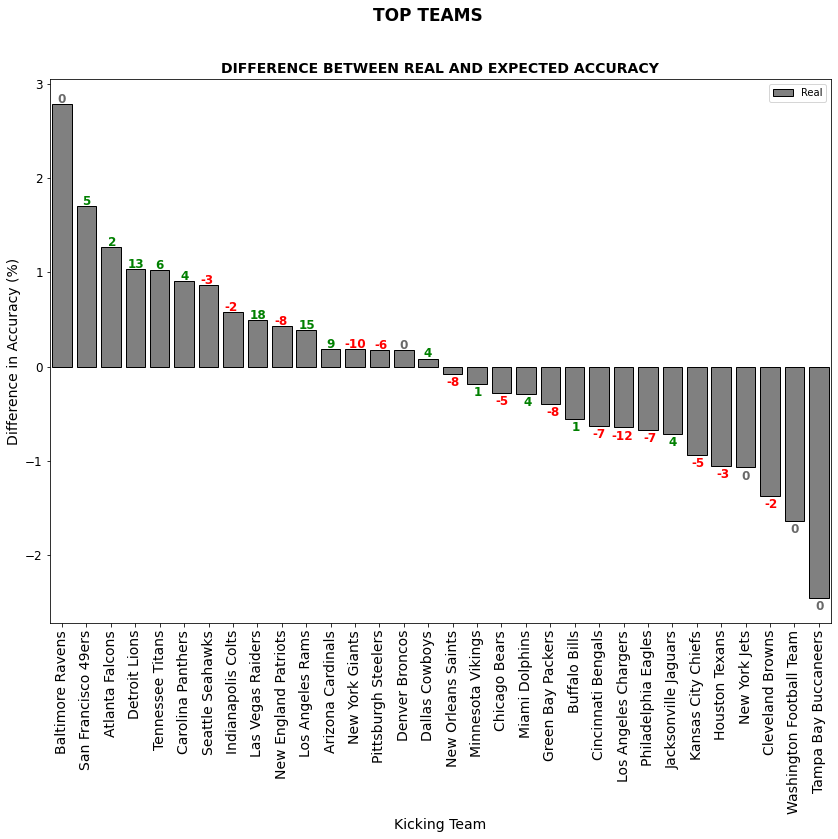

In [19]:
df_team_aux = df_team_aux.sort_values('dif', ascending = False)

plt.figure(figsize = (14,10))

ax = sns.barplot(data = df_team_aux, x = 'possession_team', y = 'dif', label = 'Real', color = 'gray', edgecolor = 'black')

plt.title('DIFFERENCE BETWEEN REAL AND EXPECTED ACCURACY', fontweight = 'bold', size = 14)
plt.suptitle('TOP TEAMS', fontweight = 'bold', size = 17)

plt.xlabel('Kicking Team', size = 14)
plt.ylabel('Difference in Accuracy (%)', size = 14)
plt.legend()
plt.xticks(rotation = 90)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=14)


lista_correction = [
    (-0.19,0),(-0.19,0.02),(-0.1,-0.02),(-0.3,0.05),(-0.2,0.04),(-0.15,0.02),(-0.32,-0.02),(-0.35,-0.01),(-0.3,0.01), #9
    (-0.3,0.04),(-0.3,0.0),(-0.18,0),(-0.42,0),(-0.2,-0.01),(-0.17,-0.01),(-0.18,0),(-0.25,-0.11),(-0.12,-0.11), #18
    (-0.25,-0.11),(-0.1,-0.12), (-0.15,-0.12),(-0.14,-0.08),(-0.28,-0.16),(-0.48,-0.18),(-0.2,-0.1),(-0.17,-0.14), #26
    (-0.2,-0.17),(-0.2,-0.08),(-0.17,-0.1),(-0.25,-0.1),(-0.16,-0.17),(-0.16,-0.08)]
for index, value in enumerate(df_team_aux["dif"].round(1)):
    if df_team_aux.loc[index, 'rank_var'] < 0:
        plt.text(index + lista_correction[index][0], value + lista_correction[index][1], df_team_aux.loc[index, 'rank_var'], color='red', fontweight="bold", fontsize=12)#, verticalalignment='center')
    elif df_team_aux.loc[index, 'rank_var'] == 0:
        plt.text(index+ lista_correction[index][0], value + lista_correction[index][1], df_team_aux.loc[index, 'rank_var'], color='dimgray', fontweight="bold", fontsize=12)#, verticalalignment='center')
    else:
        plt.text(index + lista_correction[index][0], value + lista_correction[index][1], df_team_aux.loc[index, 'rank_var'], color='green', fontweight="bold", fontsize=12)#, verticalalignment='center')



Some notes:

- A lot of teams were misjudged from our previous metric! Teams like the Lions, Raiders and Rams were much better than they seemed, and teams like the Chargers, Giants and Saints had a much better position than they deserved.
- The Ravens performance is outstanding! Not only they had the highest accuracy, they also had the biggest lift between the expected performance and the real. For opposite reasons, the Tampa Bay Buccaneers is not that great...
- The biggest change in the rank was from the Las Vegas Raiders! They were previously ranked as the 27th, and with the new metric, they ended up in 9th, climbing 18 positions.

***

### Best Players

Now, we are going to evaluate the best players, running the same logic. We'll filter only players that have at least 120 attempts, which is roughly 2 complete seasons. This number is a little high, but our method does not work well for a small volume of data.

In [20]:
df_kickers_aux = df.groupby('kicker_name').count()[['game_id']].reset_index().rename({'game_id':'kicks'}, axis = 1)
df_kickers_aux = df_kickers_aux[df_kickers_aux['kicks']>=120]

In [21]:
df_kickers = run_simulations(df_kickers_aux, 'kicker_name', 10000).sort_values('accuracy', ascending = False)
df_kickers = df_kickers.merge(df_kickers_aux, on = 'kicker_name')
df_kickers

,kicker_name,accuracy,expected_accuracy,dif,rank_var,kicks
0,J.Tucker,95.871560,89.755352,6.116208,0,654
1,N.Kaeding,95.855856,95.315315,0.540541,-23,555
2,M.Vanderjagt,95.192308,96.153846,-0.961538,-46,208
3,M.Andersen,95.180723,95.180723,0.000000,-31,166
4,J.Carney,94.933333,95.466667,-0.533333,-37,375
...,...,...,...,...,...,...
65,C.Sturgis,88.118812,90.759076,-2.640264,-2,303
66,B.Maher,87.878788,88.636364,-0.757576,21,132
67,Z.Gonzalez,87.628866,89.690722,-2.061856,4,194
68,J.Slye,87.500000,87.500000,0.000000,35,120


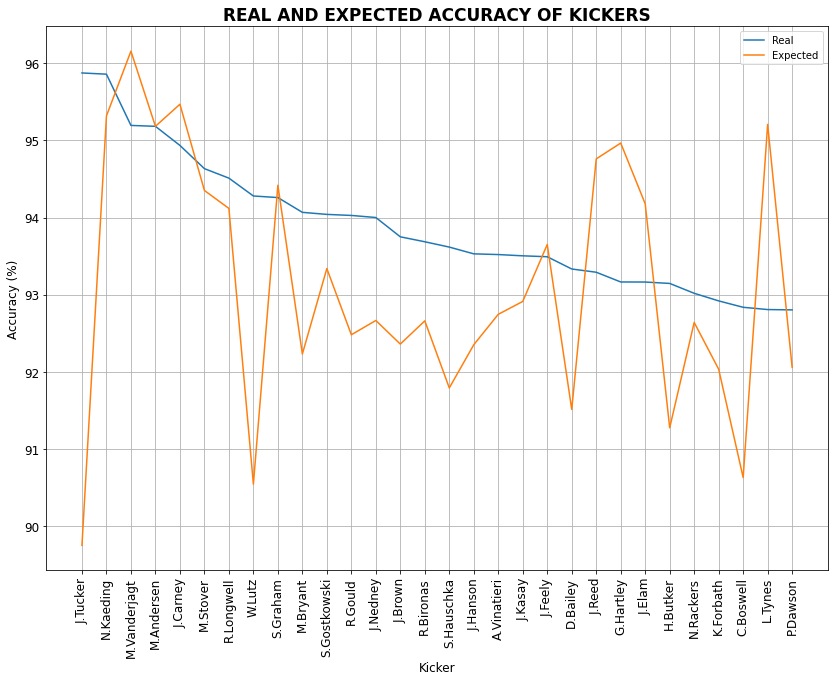

In [22]:
plt.figure(figsize = (14,10))
df_kickers = df_kickers.sort_values('accuracy', ascending = False).reset_index(drop = True)
ax = sns.lineplot(data = df_kickers[:30], x = 'kicker_name', y = 'accuracy', label = 'Real')
ax = sns.lineplot(data = df_kickers[:30], x = 'kicker_name', y = 'expected_accuracy', label = 'Expected')
plt.title('REAL AND EXPECTED ACCURACY OF KICKERS', fontweight = 'bold', size = 17)
plt.xlabel('Kicker', size = 12)
plt.ylabel('Accuracy (%)', size = 12)
plt.legend()
plt.xticks(rotation = 90)
plt.grid()

ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12);

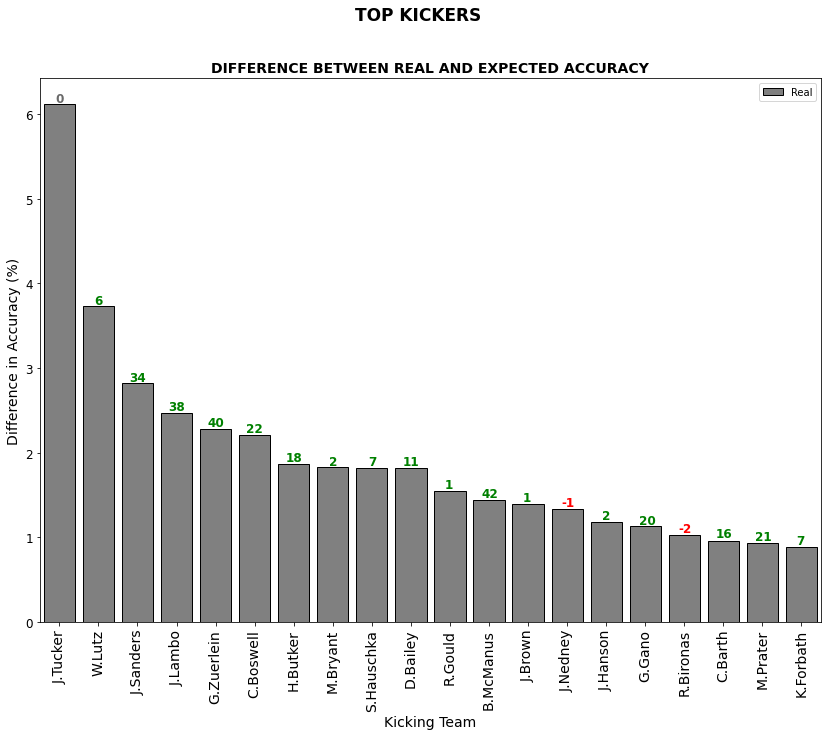

In [23]:
df_kickers = df_kickers.sort_values('dif', ascending = False).reset_index(drop = True)
plt.figure(figsize = (14,10))


ax = sns.barplot(data = df_kickers[:20], x = 'kicker_name', y = 'dif', label = 'Real', color = 'gray', edgecolor = 'black')

plt.title('DIFFERENCE BETWEEN REAL AND EXPECTED ACCURACY', fontweight = 'bold', size = 14)
plt.suptitle('TOP KICKERS', fontweight = 'bold', size = 17)

plt.xlabel('Kicking Team', size = 14)
plt.ylabel('Difference in Accuracy (%)', size = 14)
plt.legend()
plt.xticks(rotation = 90)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=14)
lista_correction = [
(-0.11,0.04), 
(-0.1,0.06),
(-0.2,0.05), #34
(-0.2,0),  #38
(-0.2,0.01), #40
(-0.22,0.04),  #22
(-0.21,0),  #18
(-0.09,0.05), # 2
(-0.1,0.05), # 7
(-0.21,0.05), # 11
(-0.13,0.08),  # 1
(-0.18,0.07), # 42
(-0.14,0.03),  # 1
(-0.16,0.07), # -1
(-0.12,0.02), # 2
(-0.15,0.05),  # 20
(-0.15,0.06), # -2
(-0.2,0.0), # -16
(-0.18,0.07), # 21
(-0.13,0.02)]# 7


for index, value in enumerate(df_kickers[:20]["dif"].round(1)):
    if df_kickers[:20].loc[index, 'rank_var'] < 0:
        plt.text(index + lista_correction[index][0], value + lista_correction[index][1], df_kickers[:20].loc[index, 'rank_var'], color='red', fontweight="bold", fontsize=12)#, verticalalignment='center')
    elif df_kickers.loc[index, 'rank_var'] == 0:
        plt.text(index + lista_correction[index][0], value + lista_correction[index][1], df_kickers[:20].loc[index, 'rank_var'], color='dimgray', fontweight="bold", fontsize=12)#, verticalalignment='center')
    else:
        plt.text(index + lista_correction[index][0], value + lista_correction[index][1], df_kickers[:20].loc[index, 'rank_var'], color='green', fontweight="bold", fontsize=12)#, verticalalignment='center')

        ;

- The change between ranks is big here. Some players gained more than 40 positions! 
- You tought Justin Tucker was good? Turns out he is just out of this world!
- Kudos to Lutz too!

## Do the kickers feel the pressure? How do their performance change when playing away? And in games against a divisional rival? How about in crucial moments?
***



### Home vs Away
First, let's compare some stats between kicks home and away.

In [24]:
# create column to indicate if the kicker is at home or away
df['kick_from_home_team'] = np.where(df['possession_team']==df['home_team'], 1, 0)

# create column to indicate if the kick surpassed the expectations, and by how much
df['dif_index'] = df['scored'] - df['scoring_prob']

print("The real accuracy from home is:", round(df[df['kick_from_home_team']==1].mean()['scored']*100,2),"%")
print("The expected accuracy from home is:", round(df[df['kick_from_home_team']==1].mean()['scoring_prob']*100,2),"%")

print("The real accuracy away from home is:", round(df[df['kick_from_home_team']==0].mean()['scored']*100,2),"%")
print("The expected accuracy away from home is:", round(df[df['kick_from_home_team']==0].mean()['scoring_prob']*100,2),"%")

The real accuracy from home is: 92.65 %
The expected accuracy from home is: 92.41 %
The real accuracy away from home is: 91.68 %
The expected accuracy away from home is: 91.95 %


The stats indicates that the accuracy from home kicks are higher, and surpassed the expected accuracy. The same can't be said about the kicks away from home. 

Nevertheless, let's run a permutation test, so we can confirm that suspicious.

To evaluate if the performance is different, we are going to run a permutation test, on both groups, using the "dif_index" column. You can have a great intuition of what the test does, checking this awesome interactive website.
https://www.jwilber.me/permutationtest/

In [25]:
home_kicks = df[df['kick_from_home_team']==1]['dif_index']
away_kicks = df[df['kick_from_home_team']==0]['dif_index']

p_value = permutation_test(away_kicks, home_kicks,
                           method='approximate',
                           num_rounds=10000,
                           seed=123)
print(p_value)

0.048095190480951906


The p_value was under 0.05! **We can confirm that the kickers are better at home, that away from home!**

### Crucial Moments

First of all, let's define crucial moments as the kicks in the second half of the game that can change the lead or tie the match. In these situations, we can expect that the pressure on the kicker is much higher. Does that affects a lot their performance?

In [26]:
## Creating a "crucial moment column", that indicates if that kick was taken in a crucial moment.

df['crucial_moment'] = False
df.loc[(df['quarter']>=3)&(df['home_team']==df['possession_team'])&((df['home_score_pre'] - df['visiting_score_pre'] + df['potential_pts']).isin([0,1,2,3])), 'crucial_moment'] = True
df.loc[(df['quarter']>=3)&(df['home_team']!=df['possession_team'])&((df['visiting_score_pre'] - df['home_score_pre'] + df['potential_pts']).isin([0,1,2,3])), 'crucial_moment'] = True

Again, let's see some stats between the groups

In [27]:
print("The real accuracy in crucial moments is:", round(df[df['crucial_moment']==True].mean()['scored']*100,2),"%")
print("The expected accuracy in crucial moments is:", round(df[df['crucial_moment']==True].mean()['scoring_prob']*100,2),"%")

print("The real accuracy in non-crucial moments is:", round(df[df['crucial_moment']==False].mean()['scored']*100,2),"%")
print("The expected accuracy in non-crucial moments is:", round(df[df['crucial_moment']==False].mean()['scoring_prob']*100,2),"%")

The real accuracy in crucial moments is: 87.06 %
The expected accuracy in crucial moments is: 88.14 %
The real accuracy in non-crucial moments is: 92.62 %
The expected accuracy in non-crucial moments is: 92.53 %


In [28]:
crucial = df[df['crucial_moment']==False]['dif_index']
non_crucial = df[df['crucial_moment']==True]['dif_index']
p_value = permutation_test(crucial, non_crucial,
                           method='approximate',
                           num_rounds=10000,
                           seed=123)
print(p_value)

0.016298370162983702


The p_value was under 0.05! We can confirm that the kickers have a drop in the performance in crucial moments. Comparing the p-values, this drop is more significant than weather the kicker is playing home or away.

### Divisional Games

In divisional games, usually we have some rivality involved. A lot of times, this games can be more important than the others, since you are fighting your rivals for the top of the division table. In games like these, do the kickers feel the pressure, and have a worse performance?

In [29]:
# creating a column to indicate if it is a divisional game or not
df['division_game'] = np.where(df['div_possession_team'] == df['div_non_possession_team'], 1,0)

print("The real accuracy in divisional games is:", round(df[df['division_game']==1].mean()['scored']*100,2),"%")
print("The expected accuracy in divisional games is:", round(df[df['division_game']==1].mean()['scoring_prob']*100,2),"%")

print("The real accuracy in non-divisional games is:", round(df[df['division_game']==0].mean()['scored']*100,2),"%")
print("The expected accuracy in non-divisional games is:", round(df[df['division_game']==0].mean()['scoring_prob']*100,2),"%")

The real accuracy in divisional games is: 92.28 %
The expected accuracy in divisional games is: 92.15 %
The real accuracy in non-divisional games is: 92.13 %
The expected accuracy in non-divisional games is: 92.21 %


That was not really what I expected... The performance of kickers in game between divisional rivals seems to be a little higher than the other games. Let's test if we have statistical confidence on this pattern.

In [30]:
non_division = df[df['division_game']==0]['dif_index']
division = df[df['division_game']==1]['dif_index']
p_value = permutation_test(non_division, division,
                           method='approximate',
                           num_rounds=10000,
                           seed=123)
print(p_value)

0.44715528447155284


The p value is bigher than 0.05. **We don't have statistical evidence to state that the performance of kickers in different in games between division rivals** 

## Are the kickers improving over the years?
***

First of all, let’s plot the real accuracy vs expected accuracy over the years.

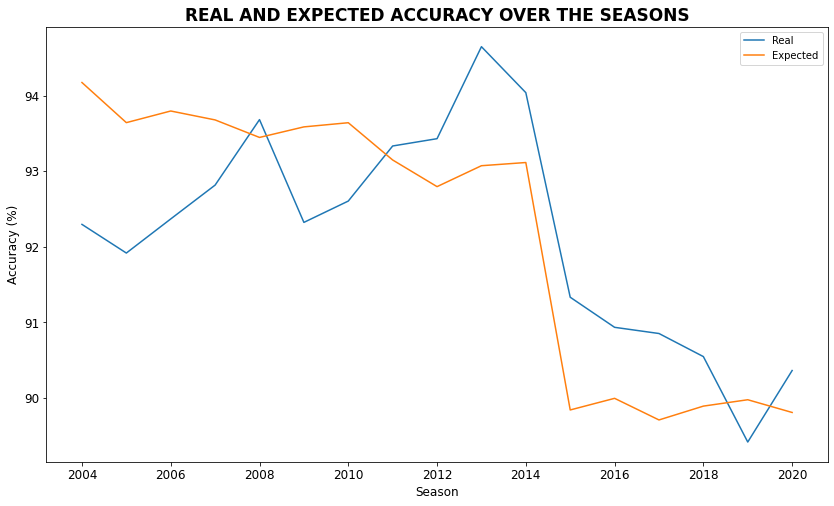

In [31]:
df_seasons = run_simulations(df, 'season', 10000).sort_values('accuracy', ascending = False)

plt.figure(figsize = (14,8))
df_seasons = df_seasons.sort_values('accuracy', ascending = False).reset_index(drop = True)
ax = sns.lineplot(data = df_seasons, x = 'season', y = 'accuracy', label = 'Real')
ax = sns.lineplot(data = df_seasons, x = 'season', y = 'expected_accuracy', label = 'Expected');
plt.title('REAL AND EXPECTED ACCURACY OVER THE SEASONS', fontweight = 'bold', size = 17)
plt.xlabel('Season', size = 12)
plt.ylabel('Accuracy (%)', size = 12)
plt.legend()

ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12);


That settles it. From this chart, we can clearly see that in the first half of the analysis, the kickers performance were bellow the expectations more often than not. The opposite happened in the second half. 

Since we have over 2000 attempts in each season, this pattern is pretty solid. Therefore, we can confirm that **the kickers are getting better over the seasons.**

*PS: in 2014, we have a big drop in the accuracy because of the change in the extra point range*

## At what ages the kicker hits his prime?
***
This question is interesting: Since the kickers don’t have the same work rate as the other positions, it’s fair to assume that they can play until an older age. Not only that, their job depends a lot on good mental preparation. More experienced players could have an advantage on that.

As we don't have the age of the kicker in the current dataset, we must gatter this information. It can be found at the players file

In [32]:
## Importing player data

players = pd.read_csv('players.csv')
players = players[players['position'] == 'K']
players = players[players['dob'].isnull()==False]
players['kicker_name'] = players['nameFirst'].str[:1]+'.'+players['nameLast']
players = players[['kicker_name','dob']]
players

,kicker_name,dob
88,A.Leavitt,1955-10-22
126,N.O'Donoghue,1953-01-18
257,R.Septien,1953-12-12
301,C.Long,1954-12-16
315,O.Johansson,1948-03-31
...,...,...
22841,T.Vizcaino,1996-07-31
22891,C.McLaughlin,1996-04-09
22997,C.Hedlund,1995-03-15
23222,J.Baron,1996-01-25


We have an issue here: We don't have a player_id on the previous df. Therefore, this join will be made using the player name as the key... we can expect that this join match won't be flawless, since we got the player name through a regex.

In [33]:
# Merging the player data to the new dataset
df_merged = df.merge(players, how = 'inner', on = 'kicker_name')

# Comparing the lenght of the original dataset, to the new one, and the number of unique play_ids
df.shape[0],df_merged.shape[0]

(35867, 35076)

Two considerations: 
<br> • Between the original dataset and the new one, we lost a little over 800 records. That's not a big deal, we still have plenty of data to our analysis.
<br> • We can see that the new dataset have some duplicates. Mostly that's because some names are very similar to the other, and we can't tell them apart. e.g: 'Josh Brown' and 'Jon Brown'. Since it's a very small number, we'll drop them.

In [34]:
## Dropping duplicated dat
df_merged = df_merged.drop_duplicates(subset=['play_id'], keep=False)

## Checking if the new dataframe have duplicated kicks
assert df_merged.shape[0] == df_merged.play_id.nunique()

In [35]:
## getting the age of the players
df_merged['gameDate'] = pd.to_datetime(df_merged['gameDate'])
df_merged['dob'] = pd.to_datetime(df_merged['dob'])
df_merged['age'] = (df_merged['gameDate'] - df_merged['dob'])/timedelta(days=365)//1
df_merged.head()

,play_id,game_id,home_team,away_team,possession_team,nonpossession_team,play_type,home_score_pre,visiting_score_pre,description,...,div_possession_team,div_non_possession_team,distance,scoring_prob,kick_from_home_team,dif_index,crucial_moment,division_game,dob,age
0,0,26909,New England Patriots,Indianapolis Colts,Indianapolis Colts,New England Patriots,Extra Point,3,3,Extra Point - Good: IND 13 (M.Vanderjagt),...,AFC_S,AFC_E,20.0,0.996214,0,0.003786,False,0,1970-03-24,34.0
1,1,26909,New England Patriots,Indianapolis Colts,Indianapolis Colts,New England Patriots,Extra Point,10,10,Extra Point - Good: IND 13 (M.Vanderjagt),...,AFC_S,AFC_E,20.0,0.996214,0,0.003786,False,0,1970-03-24,34.0
2,2,26909,New England Patriots,Indianapolis Colts,Indianapolis Colts,New England Patriots,Extra Point,27,17,Extra Point - Good: IND 13 (M.Vanderjagt),...,AFC_S,AFC_E,20.0,0.996214,0,0.003786,False,0,1970-03-24,34.0
3,179,26933,Tennessee Titans,Indianapolis Colts,Indianapolis Colts,Tennessee Titans,Extra Point,10,3,Extra Point - Good: IND 13 (M.Vanderjagt),...,AFC_S,AFC_S,20.0,0.996214,0,0.003786,False,1,1970-03-24,34.0
4,180,26933,Tennessee Titans,Indianapolis Colts,Indianapolis Colts,Tennessee Titans,Extra Point,17,10,Extra Point - Good: IND 13 (M.Vanderjagt),...,AFC_S,AFC_S,20.0,0.996214,0,0.003786,False,1,1970-03-24,34.0


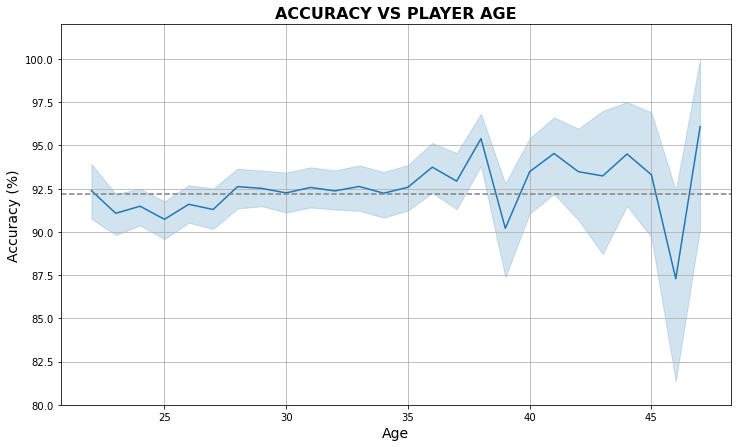

In [36]:
## Plotting the data
plt.figure(figsize = (12,7))
sns.lineplot(data = df_merged, x = 'age', y = df_merged['scored']*100)
#sns.lineplot(data = df_merged, x = 'age', y = df_merged['scoring_prob']*100)

plt.title("ACCURACY VS PLAYER AGE", fontweight = 'bold', fontsize = 16)
plt.xlabel("Age", fontsize = 14)
plt.ylabel("Accuracy (%)", fontsize = 14)
plt.axhline(y = (df['scored'].mean()*100), color = 'gray', linestyle = '--')
plt.ylim(80,102)
plt.grid();

Looking at the chart, we can see that the graph has a growing trend. I can see three groups:
- Before 28 years, the accuracy is bellow the average line 
- Between 28 and 35, the accuracy flutuates around the average 
- After that, the accuracy is mainly above the average! In the early 40's, the standard deviation starts to get huge.

Based on this data, are we 100% certain that older kickers are better than younger ones? 

#### No! We probably have a case of survivorship bias. 

"The survivorship bias is the logical error of concentrating on the people or things that made it past some selection process and overlooking those that did not, typically because of their lack of visibility"

In our case, as the kickers get older, if they don’t have enough game time, they may decide to retire. That is, older players who have not retired yet tend to be very good, since they still have a lot of gametime.


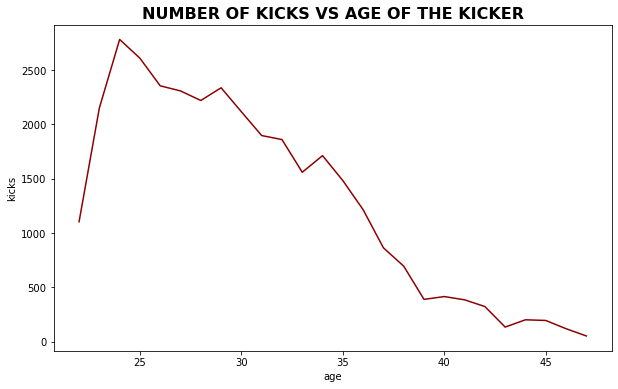

In [37]:
dummy_df = df_merged.groupby(['age'])['scored'].agg(['count', 'mean']).reset_index()
dummy_df['mean'] = dummy_df['mean'] * 100

plt.figure(figsize = (10,6))
sns.lineplot(data = dummy_df, x = 'age', y = 'count', color = 'darkred')
plt.title("NUMBER OF KICKS VS AGE OF THE KICKER", fontweight = 'bold', fontsize = 16)
plt.ylabel('kicks')
plt.plot();

Looking at the count of kicks by age, we can see that this number takes a huge drop after 35 years. This strengthens the idea that the worst players retire early, or get benched.

But even if that wasn't the case, this approach was terrible and can lead to huge mistakes: Let's make an exercise here: Imagine that in the last 3 years, we had a lot of talented players coming from the college, that simply doesn't make any mistakes. We would see a big rise in the accuracy for players under ~26, and after that the accuracy would drop, since these players have not contributed yet. In our method, it would seem that younger players are more accurate, even though that is probably not true. 

Therefore, we can’t be sure if older kicker are better than younger ones or not. This analysis is not easy to do and it would require longer periods of data. With an appropriate dataset, we could see for example, for every retired player, what age was his prime. Having only 15 years of data, that's not possible.